# Projeto de ciência de dados 2023/2024

### Este bloco de notas apresenta a realização das 3 peimeiras fazes do ciclo de anlize de dados para o projeto de ciência de dados de 2023/2024.

## Formulação do Problema


#### Categorizar o estado de saúde de um feto como normal, suspeito ou patológico, utilizando resultados de  Cardiotocogramas (CTGs) , com o objetivo de intervir precocemente para reduzir os riscos e prevenir a mortalidade materna e fetal para issso encontramos uma conjunto de dados "Fetal Health Classification" com cerca de 2000 dados e com 22 variaveis.




## Analise de dados

In [1]:
#import general libraries
import pandas as pd
import numpy as np
import itertools
import math
import seaborn as sns

# Plotting
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # Ensure all columns are displayed


class PlotTypes:
    """
        Contains plotting types names used in plot.
    """

    _all_types = ['hist', 'violin', 'box', 'scatter', 'lines', 'bar', 'lollypops']

    def hist(self) -> str:
        return self._all_types[0]

    def violin(self) -> str:
        return self._all_types[1]

    def box(self) -> str:
        return self._all_types[2]

    def scatter(self) -> str:
        return self._all_types[3]

    def lines(self) -> str:
        return self._all_types[4]

    def bar(self) -> str:
        return self._all_types[5]

    def lollypop(self) -> str:
        return self._all_types[6]

    def get_types(self, min: int, max: int) -> list:
        return self._all_types[min:max]

    @classmethod
    def hist_sturges(cls, data: np.array) -> float:
        return math.log(len(data),2)

    @classmethod
    def hist_freedman_diaconis(cls, data: pd.Series) -> int:
        bin_width = 2 * (data.quantile(0.75) - data.quantile(0.25)) / math.pow(len(data), 1/3)
        if bin_width == 0:
            return 10

        return (data.max() - data.min()) / bin_width

    @classmethod
    def hist_scots(cls, data: np.array) -> int:
        bin_width = 3.5 * data.std() / math.pow(len(data), 1/3)
        if bin_width == 0:
            return 10
        rest = 1 if (data.max() - data.min()) % bin_width != 0 else 0
        return ((data.max() - data.min()) // bin_width) + rest

class DataAnalysis:
    """
        Classe responsible for showing up the data, making it easier to analyze data sparsity, distribution, ... TODO: add docstring
    """

    def __init__(self,file="fetal_health.csv",target_name="fetal_health"):
        """
            Initialize the object with the data from the file
            :param file: name of the csv file to load and analise. Default is fetal_health.csv
        """
        self.file = file
        self.dataset = pd.read_csv(self.file)
        self.target_name = target_name
        self.target_classes = self.dataset[self.target_name].unique()

    def get_targets(self):
        """
            :return target feature Series DataFrame[target_name]:
        """
        return self.dataset[self.target_name]

    def save_as_csv(self,file) -> None:
        """
            Save the data as a csv file
            :return:
        """
        self.dataset.to_csv(file)

    def show_datainfo(self) -> None:
        """
            Shows info about the loaded data. Basic info, description, data dispersion graphs.
            :return: None
        """
        print("Info")
        self.info()
        print()
        print("\nDescription")
        self.describe()
        print()

    def show_correlations_heatmap(self,cellsize = 0.5) -> None:
        """
            Shows the correlation heatmap of the loaded dataset
            :return:
        """
        correlation_matrix = self.dataset.corr()
        size = len(self.dataset.columns) * cellsize +2
        plt.figure(figsize=(size, size))
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap')
        plt.show()

    def pre_process(self, ignore: list = []):
        """
            Removes duplicated, Remove null values, normalize, standardization
            :param ignore: list of features to ignore
            :return None:
        """
        self.remove_duplicates()
        self.remove_null_values()
        self.normalize(ignore)
        self.standardization(ignore)


    def remove_duplicates(self) -> None:
        """
            Removes duplicated values and missing values
            :return None:
        """
        print("Count before removing duplicates ", len(self.dataset))
        self.dataset.drop_duplicates(inplace=True)
        print("Count after removing duplicates ", len(self.dataset))

    def remove_null_values(self) -> None:
        """
            Removes duplicated values and missing values
            :return None:
        """
        print("Count before ", len(self.dataset))
        self.dataset.dropna(inplace=True)
        print("Count after drop rows with null values ", len(self.dataset))

    def normalize(self,ignore: list = []) -> None:
        """
            Applies min/max normalization to each column of the dataset
            and replaces the actual feature data with the normalized data.
            The result data is between 0 and 1.
            :param ignore: features to not do normalization
            :return None:
        """

        for column in self.dataset.columns:

            if (column in ignore):
                continue

            min_value = self.dataset[column].min()
            max_value = self.dataset[column].max()
            self.dataset[column] = (self.dataset[column] - min_value) / (max_value - min_value)

    def standardization(self,ignore: list = []) -> None:
        """
            Applies standardization to each column of the dataset
            and replaces the actual feature data with the standardized data.
            :param ingnore: features to not do standardization
            :return None:
        """

        for column in self.dataset.columns:

            if(column in ignore):
                continue

            mean = self.dataset[column].mean()
            std = self.dataset[column].std()
            self.dataset[column] = (self.dataset[column] - mean) / std


    def identify_outliers_Z_Score(self, threshold = float, ignore: list = []) -> (int,pd.DataFrame):
        """
            Caluculades the outliers with z score
            :param threshold: threshold for z-score comparation
            :param ignore: list of columns to ignore outliers
            :return outliers,severe_outliers,dataFrame:
                outliers: number of outliers
                severe_outliers: number of severe outliers
                dict: a dicionary containing an lits of dicionarys {"i":i, "value":value ,"severe"} per feature of the dataset
                    that are outliers
        """
        dict = {}
        count_outliers = 0
        count_outliers_severe = 0
        for column in self.dataset.columns:

            if (column in ignore):
                continue

            #calculate feature mean and std
            std = self.dataset[column].std()
            mean = self.dataset[column].mean()

            #verify each value
            column_name = column + "_ouliers"
            dict[column_name] = list()

            i = 0
            for value in self.dataset[column]:

                # check if it is outliers
                z_score = (value - mean) / std
                if np.abs(value) >= threshold  :
                    count_outliers += 1
                    # check if it is severe
                    dict[column_name].append({"i": i, "value": value, "severe": True})
                i += 1


        return count_outliers, dict

    def identify_outliers(self,ignore: list = [], outliers=1.5, severe_outliers=3.0) -> (int,int,pd.DataFrame):
        """
            Identifies outliers in the loaded DataFrame
            :param ignore: list of columns to ignore outliers
            :param outliers: value used to identify outliers
            :param severe_outliers: value used to identify severe outliers
            :return outliers,severe_outliers,dataFrame:
                outliers: number of outliers
                severe_outliers: number of severe outliers
                dict: a dicionary containing an lits of dicionarys {"i":i, "value":value ,"severe"} per feature of the dataset
                    that are outliers
        """

        dict = {}
        count_outliers = 0
        count_outliers_severe = 0
        for column in self.dataset.columns:

            if (column in ignore):
                continue

            # calculate quantiles and limits per feture
            quantiles = self.dataset[column].quantile([0.25,0.75])
            diference = quantiles[0.75] - quantiles[0.25]
            min_outliers = quantiles[0.25] - diference * outliers
            min_severe_outliers = quantiles[0.25] - diference * severe_outliers
            max_outliers = quantiles[0.75] + diference * outliers
            max_severe_outliers = quantiles[0.75] + diference * severe_outliers

            column_name =  column + "_ouliers"
            dict[column_name] = list()

            i = 0
            for value in self.dataset[column]:

                # check if it is outliers
                if(value < min_outliers or value > max_outliers):
                    count_outliers += 1
                    # check if it is severe
                    if value < min_severe_outliers or value > max_severe_outliers:
                        count_outliers_severe += 1
                        dict[column_name].append({"i": i,"value": value,"severe": True})
                    else:
                        dict[column_name].append({"i": i,"value": value,"severe": False})
                i += 1

        return count_outliers,count_outliers_severe,dict

    def print_outliers_info(self,ignore: list = [], outliers=1.5, severe_outliers=3.0, threshold=3) -> None:
        """
            Calculates and prints out the outliers
            Identifies outliers in the loaded DataFrame
            :param ignore: list of columns to ignore outliers
            :param outliers: value used to identify outliers
            :param severe_outliers: value used to identify severe outliers
            :return None:
        """

        print("Number of outliers with interquertile range!")
        outliers, severe_outliers, data = self.identify_outliers(ignore=ignore, outliers=outliers, severe_outliers=severe_outliers)
        print("number of outliers: ", outliers, " of " , self.getNumberOfValues() ,
              " ", (outliers/self.getNumberOfValues()) * 100  , " %" , " severe: ", severe_outliers)
        for key in data.keys():
            severe = 0
            for outlier in data[key]:
                if outlier["severe"]:
                    severe +=1
            print( key, len(data[key]) , "severe: " , severe )
        print()

        print("Number of outliers with z score!")
        outliers, data = self.identify_outliers_Z_Score(ignore=ignore, threshold=threshold)
        print("number of outliers: ", outliers, " of ", self.getNumberOfValues(),
              " ", (outliers / self.getNumberOfValues()) * 100, " %")
        for key in data.keys():
            print(key, len(data[key]))
        print()


    def view_features_pairwyse(self) -> None:
        """
            Prints each feature pairwyse
            :return None:
        """
        plt.figure()  # Create a new figure
        sns.pairplot(self.dataset, hue=self.target_name, markers='o')
        plt.show()

    def describe(self) -> None:
        """
            Show the description of the loaded dataset: Feature mean median std min max q25 q50 q75
            :return: None
        """
        print(self.dataset.describe())

    def info(self) -> None:
        """
            Print information about the loaded dataset
            :return None:
        """
        self.dataset.info()

    def correlations(self) -> None:
        """
            Print correlaion of each feature of the loaded dataset
            :return None:
        """
        self.dataset.corr()

    def getNumberOfValues(self):
        """
            :return number of values in the loaded dataset:
        """
        return len(self.dataset) * len(self.dataset.columns)

    def plot_features(self,plot_types: list, columns=4, hist_number_of_bars_func=lambda x: 10, plot_size=5 , ignore: list = []) -> None:
        """
            Plot features per class label using matplotlib, and it plots the plot_types specified in plot_types.

            :param ignore: list of features to ingore
            :param plot_types: An array specifying the type of plot to generate for each feature.Supported plot types: All in PlotTypes
            :param columns: Number of features to per row
            :param hist_number_of_bars_func: function that return the number of bins to the histogram based on the data
            :param plot_size: Size of each plot

            :return None:
        """

        target = "fetal_health"

        # For each plot, need to produce a subplot for each feature, and then, for the current subplot, check the data
        # related to each label
        for plot_type in plot_types:
            # Create a figure with a single row and subplots for each feature in different columns, with width of 15
            # inches and height of 5 inches, fig represents the entire figure, while axes is an array of axes objects
            # representing each subplot (in this case it will be a one-dimensional array containing references to each
            # subplot)
            number_of_features = len(self.dataset.columns)
            rows = number_of_features//columns
            number_of_rows = rows if number_of_features % columns == 0 else rows + 1

            fig, axes = plt.subplots(nrows=number_of_rows, ncols=columns, figsize=(number_of_rows*plot_size, columns*plot_size))

            i = 0
            for feature in self.dataset.columns:

                if feature in ignore:
                    continue

                # Produce the subplot for each feature
                # two-dimensional array containing references to each subplot
                ax = axes[i // columns ][i % columns]
                hist_bins = int(hist_number_of_bars_func(self.dataset[feature]))
                ax.set_title(feature)
                i += 1

                # for each classification in target draw a graph in the same feature
                for label in self.dataset[target].unique():

                    # select the data of the class label and then get the feature data
                    feature_data = self.dataset[self.dataset[target] == label][feature]

                    # Plot according to the specified plot type
                    if plot_type == 'hist':
                        ax.hist(feature_data, bins=hist_bins, alpha=0.25)
                        # Set plot labels
                        ax.set_xlabel(f'Class')
                        ax.set_ylabel(f'Frequency')

                    elif plot_type == 'violin' and target != "":
                        ax.violinplot(feature_data, showmeans=True, showmedians=True, positions=[label])
                        # Set plot title and labels
                        ax.set_xlabel("Class")
                        ax.set_ylabel("Values")

                    elif plot_type == 'box':
                        ax.boxplot(feature_data, vert=True, positions=[label])
                        ax.set_xlabel("Class")
                        ax.set_ylabel("Values")

                    elif plot_type == 'scatter':
                        # Define the x axis line to go from 0 to len(feature_data) (because first label is 0) then from
                        # then from len(feature_data) to 2*len(feature_data) (because first label is 1) and so one
                        x_axis = np.arange(len(feature_data)) + len(feature_data) * label
                        ax.scatter(x_axis, feature_data, label=f'Class {int(label)}')
                        ax.legend()

                    elif plot_type == 'lines':
                        ax.plot(feature_data, label=f'Class {int(label)}')
                        ax.legend()

                    elif plot_type == 'bar':
                        x_axis = np.arange(len(feature_data)) + len(feature_data) * label
                        ax.bar(x_axis, feature_data, label=label)
                        ax.legend()

                    elif plot_type == 'lollypops':
                        x_axis = np.arange(len(feature_data)) + len(feature_data) * label
                        ax.stem(x_axis, feature_data, linefmt='-', label=label)
                        ax.legend()

            # Adjust layout
            plt.tight_layout()
            # Show plot
           # plt.savefig('teste.png')
            plt.show()


### Carregar o data set
#### Os valores por defeito sao file="fetal_health.csv" target_name="fetal_health".

In [2]:
data_analyze = DataAnalysis()

### Pré processamento 
#### Realizamos a remoção de valores null, duplicados, normalização e standartização paras todas as variveis exeto a vaeriavelobjetivo.  

In [3]:
data_analyze.pre_process(
        ignore=[data_analyze.target_name]
    )

Count before removing duplicates  2126
Count after removing duplicates  2113
Count before  2113
Count after drop rows with null values  2113


### Analizamos a distribuição utilizando gráficos, histogramas e de violino
#### Nos histogramas utilizamos formula de scots para determinar o número de barras a mostrar. 



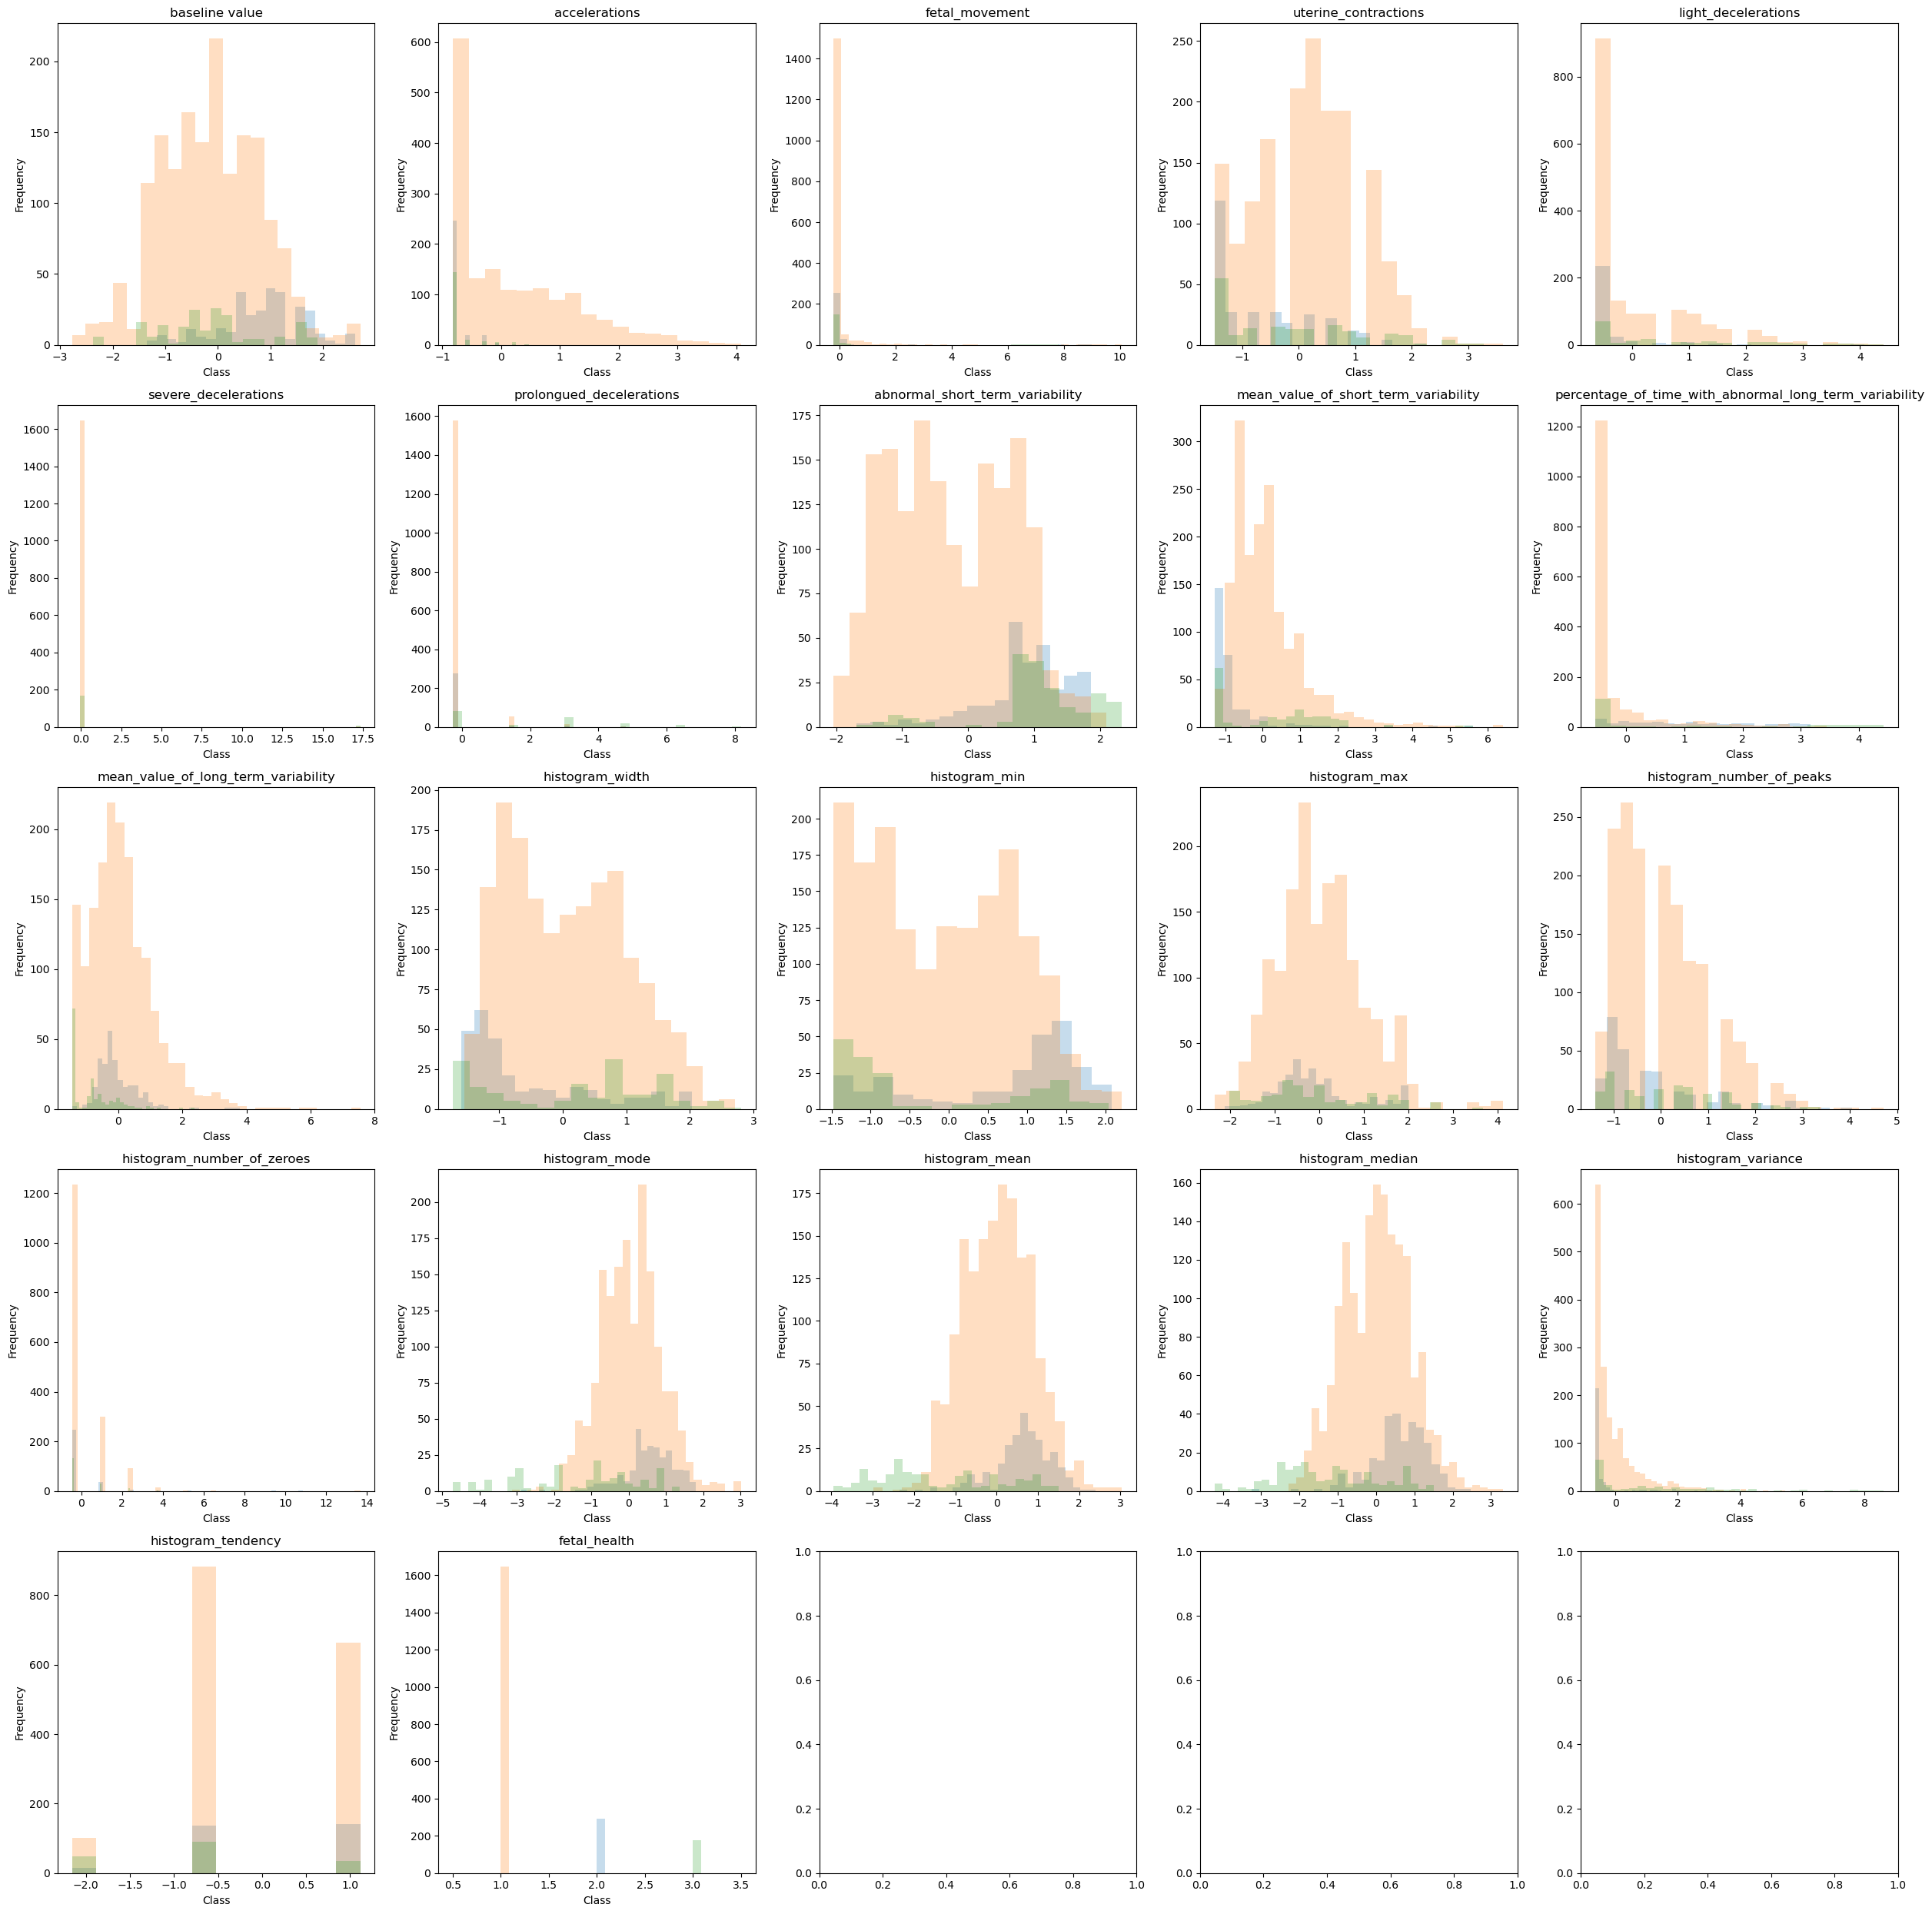

In [4]:
data_analyze.plot_features([
        PlotTypes().hist(),
        ], hist_number_of_bars_func=PlotTypes.hist_scots,
        columns=5,
        plot_size=5
        )


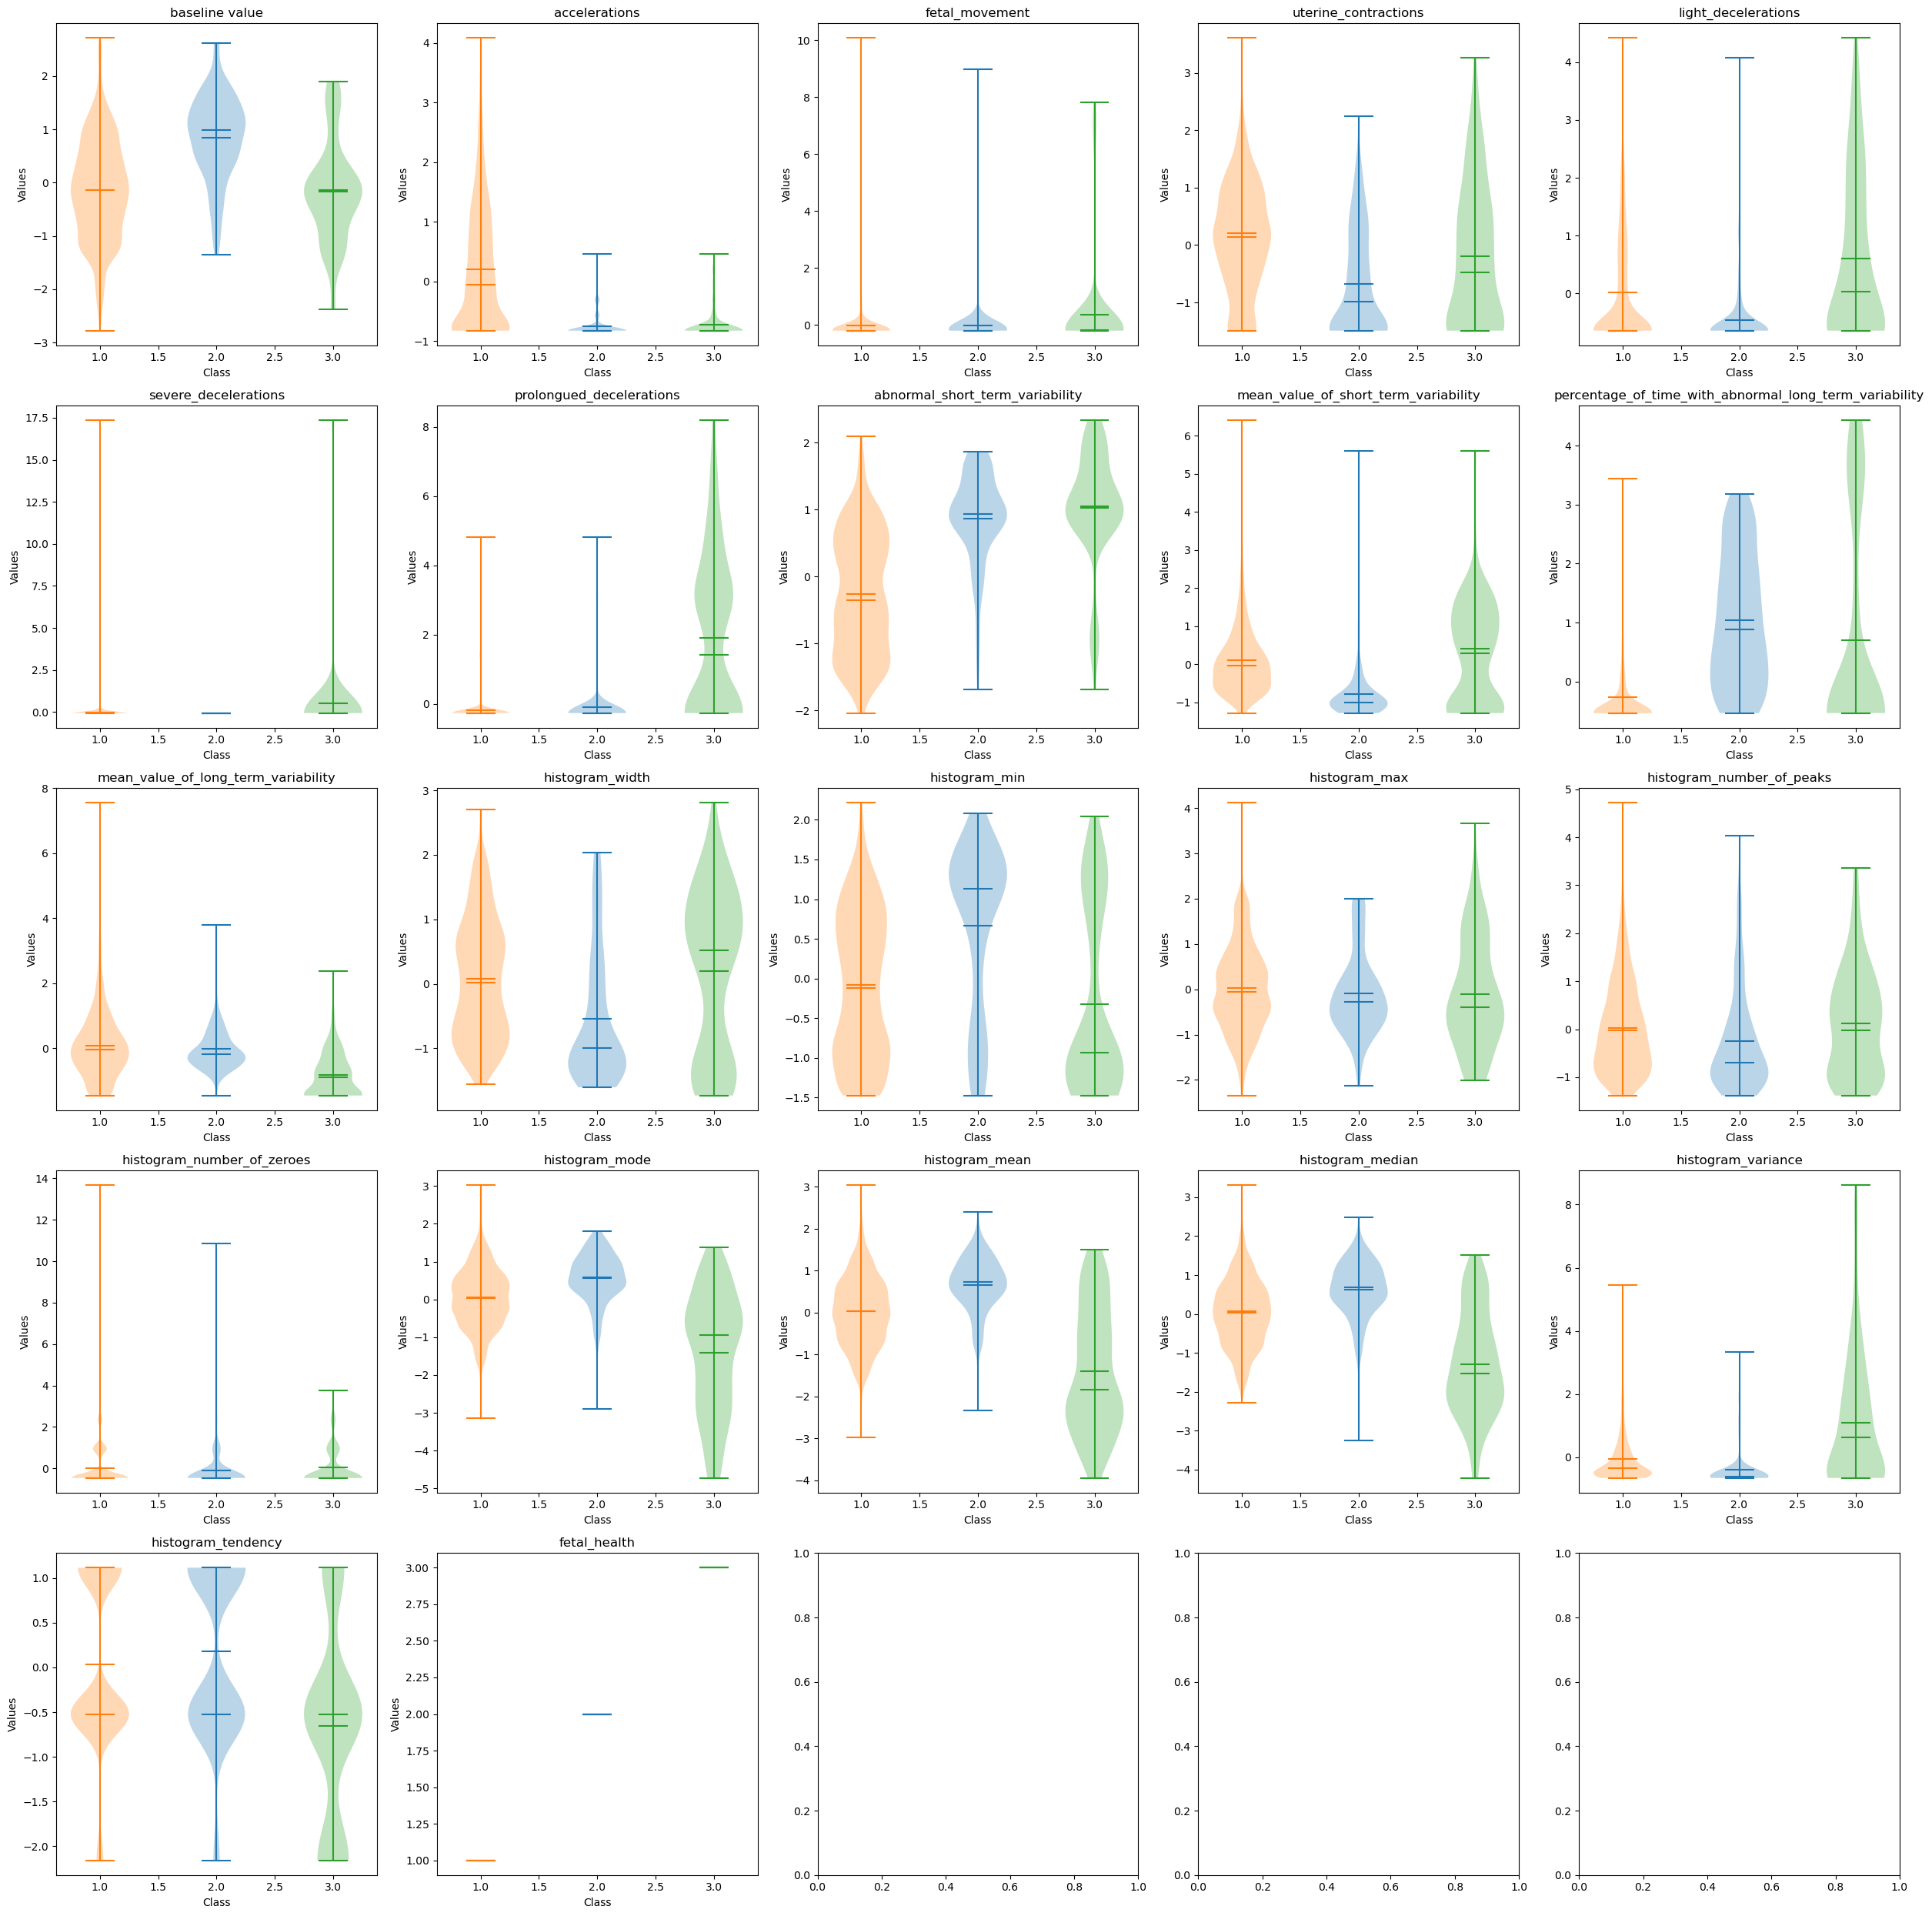

In [5]:
data_analyze.plot_features([
        PlotTypes().violin(),
        ], hist_number_of_bars_func=PlotTypes.hist_scots,
        columns=5,
        plot_size=5
        )

#### Na analize de outlieirs utilizamos o metodo da diferença entre quartis e com o metodo do Z-Score.

In [6]:
data_analyze.print_outliers_info(ignore=[data_analyze.target_name])

Number of outliers with interquertile range!
number of outliers:  1976  of  46486   4.25074215892957  %  severe:  1206
baseline value_ouliers 0 severe:  0
accelerations_ouliers 14 severe:  0
fetal_movement_ouliers 305 severe:  219
uterine_contractions_ouliers 1 severe:  0
light_decelerations_ouliers 150 severe:  18
severe_decelerations_ouliers 7 severe:  7
prolongued_decelerations_ouliers 178 severe:  178
abnormal_short_term_variability_ouliers 0 severe:  0
mean_value_of_short_term_variability_ouliers 70 severe:  18
percentage_of_time_with_abnormal_long_term_variability_ouliers 305 severe:  168
mean_value_of_long_term_variability_ouliers 71 severe:  9
histogram_width_ouliers 0 severe:  0
histogram_min_ouliers 0 severe:  0
histogram_max_ouliers 24 severe:  0
histogram_number_of_peaks_ouliers 19 severe:  1
histogram_number_of_zeroes_ouliers 502 severe:  502
histogram_mode_ouliers 73 severe:  13
histogram_mean_ouliers 45 severe:  0
histogram_median_ouliers 28 severe:  0
histogram_variance

### Fizemos gráficos de caixa de bigodes para vizualizar os outliers

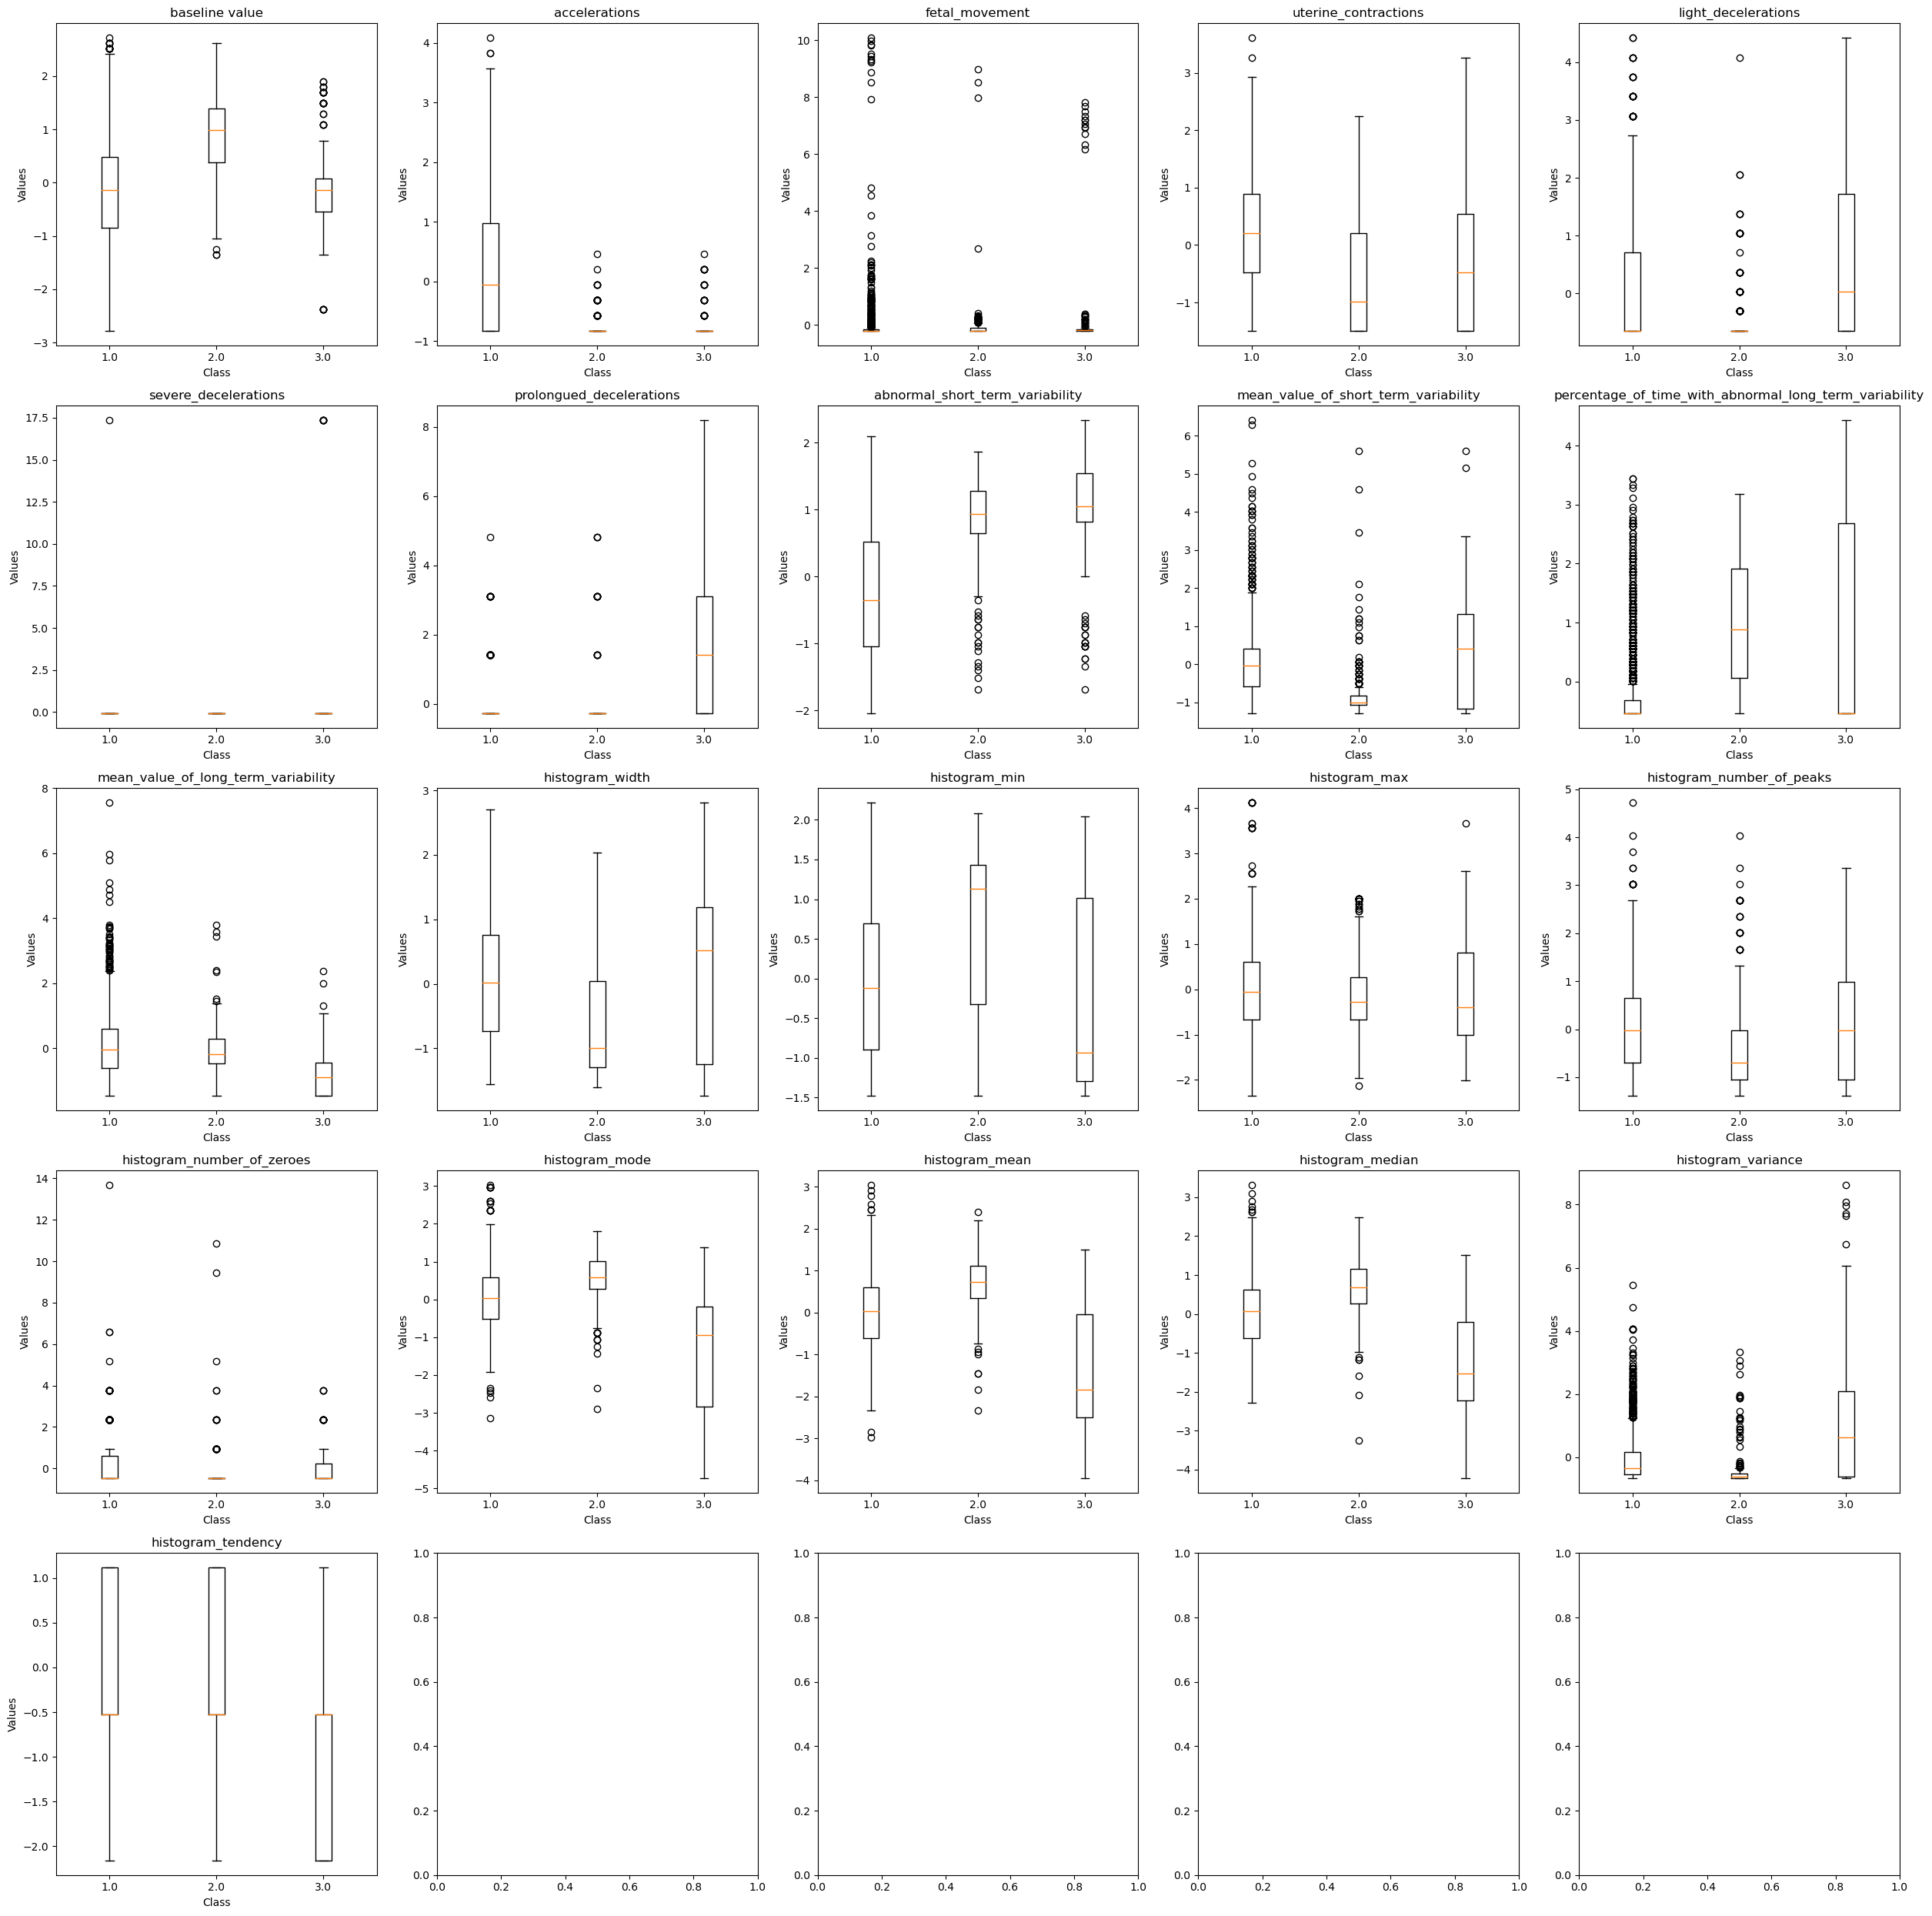

In [10]:
data_analyze.plot_features([
        PlotTypes().box(),
        ], hist_number_of_bars_func=PlotTypes.hist_scots,
        columns=5,
        plot_size=5 ,
        ignore=[data_analyze.target_name]
        )

### Como forma de extrair mais informação das variavei exegistentes seguimos com a criação de novas variaveis
#### 


In [21]:
import numpy as np
import pandas as pd
from mrmr import mrmr_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


class FeatureExtraction:
    """
        TODO: add docstring
    """

    categories = {"Very Low": 1, "Low": 2, "Medium": 3, "High": 4, "Very High": 5}

    @classmethod
    def equalize_categories(cls, _list: list):
        """
            :param _list:
            :return list:With all array with the same len
        """

        min_length = -1
        for array in _list:
            if len(array) <= min_length or min_length == -1:
                min_length = len(array)

        l = list()
        for i, array in enumerate(_list):
            if len(array) != min_length:
                random_numbers = np.random.choice(array, size=min_length, replace=False)
                l.append(random_numbers)
            else:
                l.append(array)

        return l



    @classmethod
    def _create_default_features(cls, dataset: pd.DataFrame) -> pd.DataFrame:
        """
            Creates the default features. Mean,Std,min,max,median ...
            :param dataset: The dataset to be used for adding features
            :return None:
        """

        # Calculate the mean by row
        dataset['row_mean'] = dataset.mean(axis=1)

        # Calculate the median by row
        dataset['row_median'] = dataset.median(axis=1)

        # Calculate the min by row
        dataset['row_min'] = dataset.min(axis=1)

        # Calculate the max by row
        dataset['row_max'] = dataset.max(axis=1)

        # Calculate the variance by row
        dataset['row_variance'] = dataset.var(axis=1)

        return dataset

    @classmethod
    def _create_other_features(cls, dataset: pd.DataFrame) -> pd.DataFrame:
        """

        :param dataset:
        :param targets:
        :return:
        """

        # dataset['Column_test_1'] = (
        #     dataset["mean_value_of_short_term_variability"] * dataset["abnormal_short_term_variability"])
        #
        # dataset['Column_test_2'] = (
        #     dataset["mean_value_of_long_term_variability"] * dataset["percentage_of_time_with_abnormal_long_term_variability"])

        dataset['Column_test_3'] = (
            dataset["baseline value"] * dataset["abnormal_short_term_variability"]
        )

        dataset['Column_test_4'] = (
            dataset["baseline value"] * dataset["uterine_contractions"]
        )

        dataset['Column_test_5'] = (
                dataset["baseline value"] * dataset["accelerations"]
        )

        # dataset['Column_test_6'] = (
        #         dataset["baseline value"] * dataset["fetal_movement"]
        # )

        dataset['Column_test_9'] = (
            (dataset['uterine_contractions'] * dataset["histogram_number_of_peaks"])
        )

        # Interaction between "Fetal Movement" and "accelerations"
        dataset['interaction_uterine_fetal'] = dataset['uterine_contractions'] * dataset['fetal_movement']

        # Interaction between "Fetal Movement" and "accelerations"
        dataset['interaction_movement_accelerations'] = dataset['fetal_movement'] * dataset['accelerations']

        # Calculate and store the rolling mean of 'accelerations' with a specified time window.
        time_window = 3
        dataset['rolling_mean_accelerations'] = dataset['accelerations'].rolling(window=time_window).mean()

        # Calculate the Skewness by row
        # If skewness is greater than 0, indicates that the right tail of the distribution
        # is longer or fatter than the left tail.
        # If it lower than 0 then the right tail is longer or flatter and if 0 is normal distribution
        dataset['row_skewness'] = dataset.skew(axis=1)

        # Calculate the Kurtosis by row
        dataset['row_kurtosis'] = dataset.kurtosis(axis=1)

        # Sum of each line
        dataset['sum_rows'] = dataset.iloc[:, :].sum(axis=1)

        return dataset

    @classmethod
    def _create_categorical_feature(cls, dataset: pd.DataFrame, new_feature_name: str, column_name: str) -> pd.DataFrame:
        """
            Creates categorical features for column specified by <FeatureEngineering.categories>
            :param column_name: feature name.
            :param new_feature_name: name of the categorical feature created.
            :param dataset: dataset that a new feature will be added
            :return dataset: the dataset with a new feature added
        """

        # Define the bins and labels for the categorical binning
        accelerations_min = dataset[column_name].min()
        accelerations_max = dataset[column_name].max()
        accelerations_interval = (accelerations_max - accelerations_min) / len(FeatureExtraction.categories)

        # Calculating the values that separate the bins
        bins = [accelerations_min]
        while bins[-1] < accelerations_max:
            bins.append(bins[-1] + accelerations_interval)

        # Perform categorical binning for a specific column, e.g., 'accelerations'
        dataset[new_feature_name] = (
            pd.cut(dataset[column_name], bins=bins, labels=FeatureExtraction.categories,
                   include_lowest=True))

        # Transform categorical to int starting from 1
        dataset[new_feature_name] = (dataset[new_feature_name].cat.codes + 1).astype(int)

        return dataset

    @classmethod
    def create_features(cls, dataset: pd.DataFrame, targets: list) -> pd.DataFrame:
        """
            Creates the default features. Mean,Std,min,max,median ...
            :param dataset: The dataset to be used for adding features
            :param targets: The targets features to place in the end
            :return DataFrame: A DataFrame containing all the features
        """

        # Removing columns to ignore
        dataset_targets = dict()
        for target in targets:
            dataset_targets.update({target: dataset.pop(target)})

        dataset = cls._create_default_features(dataset)
        dataset = cls._create_other_features(dataset)
        dataset = cls._create_categorical_feature(dataset, "accelerations_category", "accelerations")
        dataset = cls._create_categorical_feature(dataset, "fetal_movement_category", "fetal_movement")

        # Adding ignored columns to the end of the dataset
        for key in dataset_targets.keys():
            dataset[key] = dataset_targets[key]

        return dataset


class FeatureSelector:
    def __init__(self, data, labels):
        """
        Initialize the FeatureSelector instance.

        Parameters:
        - data (numpy.ndarray): The input data array with shape (n_samples, n_features).
        - labels (numpy.ndarray): The labels array with shape (n_samples,).
        """
        self.data = data
        self.labels = labels

    def select_features_mrmr(self, k=5):
        """
        Select features using mRMR (minimum Redundancy Maximum Relevance).

        Parameters:
        - k (int): The number of features to select. Default is 5.

        Returns:
        - List: The selected features as a list.
        """
        # Return the selected features
        return mrmr_classif(X=self.data, y=self.labels, K=k)

    def select_features_sequential(self, k=5):
        """
        Select features using sequential feature selection with LDA as the classifier.

        Parameters:
        - k (int): The number of features to select. Default is 5.

        Returns:
        - numpy.ndarray: The selected features array with shape (n_samples, k).
        """
        # Sequential forward feature selection
        sfs = SequentialFeatureSelector(LinearDiscriminantAnalysis(), n_features_to_select=k,
                                        direction='forward').fit(self.data, self.labels)
        # Return the selected features
        return self.data.loc[:, sfs.get_support()].columns


In [22]:
data_analyze.dataset = FeatureExtraction.create_features(data_analyze.dataset, [data_analyze.target_name])

### Depois verificamos se foram criados valores duplicados ou nulos e procedemos a sua remoção

In [ ]:
data_analyze.remove_null_values(ignore=[data_analyze.target_name, "accelerations_category", "fetal_movement_category"])
data_analyze.remove_duplicates(ignore=[data_analyze.target_name, "accelerations_category", "fetal_movement_category"])

### Realizamos redução de dimenções. Para isso fizemos o grafico de explained varience ratio de forma a identificar o numero de componentes a manter com vista a atingir um minimo de 80% de cobertura do dataset.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


class PCAAnalysis:
    """
    Perform Principal Component Analysis (PCA) on a dataset using a developed method and a standard library.

    Attributes:
        X (numpy.ndarray): Input data array.
        y (numpy.ndarray): Target labels.
        num_components (int): Number of principal components.
        X_standardized (numpy.ndarray): Standardized input data.
        cov_matrix (numpy.ndarray): Covariance matrix of standardized data.
        eigenvalues (numpy.ndarray): Eigenvalues of covariance matrix.
        eigenvectors (numpy.ndarray): Eigenvectors of covariance matrix.
        pca_projection (numpy.ndarray): Projection of data onto principal components (manual PCA).
        sklearn_pca_projection (numpy.ndarray): Projection of data onto principal components (library PCA).
        sklearn_pca (sklearn.decomposition.PCA): Trained sklearn PCA object.
    """

    def __init__(self, data, targets, num_components):
        """
        Initialize PCAAnalysis with input data, targets, and number of principal components.

        Args:
            data (numpy.ndarray): Input data.
            targets (numpy.ndarray): Target labels.
            num_components (int): Number of principal components.

        Raises:
            ValueError: If the number of components exceeds the number of features.
        """
        if num_components > data.shape[1]:
            raise ValueError("Number of components cannot exceed the number of features.")

        # Dataset
        self.X = data
        self.y = targets

        # Configuration
        self.num_components = num_components

        # Plots
        self.fig, self.axes = None, None

        # Implemented PCA
        self.X_standardized = self._standardize_data()
        self.cov_matrix = self._compute_covariance_matrix()
        self.eigenvalues, self.eigenvectors = self._compute_eigenvalues_eigenvectors()
        self.eigenvalues, self.eigenvectors = self._sort_eigenvectors()
        self.pca_projection = self._project_data()

        # Library PCA
        self.sklearn_pca_projection, self.sklearn_pca = self._apply_sklearn_pca()

    # Single underscore _: Indicates that the attribute is protected, but it's still accessible from outside the class.
    # It's a convention, not enforced by the language itself.
    # Double underscores __: Indicates that the attribute is private, and name mangling is applied. Accessing these
    # attributes from outside the class is more difficult and discouraged (example, for a method __foo the interpreter
    # replaces this name with _classname__foo).
    def _standardize_data(self):
        """
        Step 1: Standardize the dataset.
        """
        return StandardScaler().fit_transform(self.X)

    def _compute_covariance_matrix(self):
        """
        Step 2: Compute the covariance matrix.
        """
        return np.cov(self.X_standardized.T)

    def _compute_eigenvalues_eigenvectors(self):
        """
        Step 3: Compute the eigenvectors and eigenvalues.
        """
        return np.linalg.eig(self.cov_matrix)

    def _sort_eigenvectors(self):
        """
        Step 4: Sort eigenvectors based on eigenvalues.
        """
        sorted_indices = np.argsort(self.eigenvalues)[::-1]
        return self.eigenvalues[sorted_indices], self.eigenvectors[:, sorted_indices]

    def _project_data(self):
        """
        Step 5: Select the number of principal components and project the data onto them.
        """
        return self.X_standardized.dot(self.eigenvectors[:, :self.num_components])

    def _apply_sklearn_pca(self):
        """
        Apply PCA using sklearn (for comparison).
        """
        pca = PCA(n_components=self.num_components)
        return pca.fit_transform(self.X_standardized), pca

    def print_pca_projection(self):
        """
        Show the first lines of the developed and the library PCA projection.
        """
        print("PCA Projection (Manual):\n", self.pca_projection[:5])
        print("\nPCA Projection (Sklearn):\n", self.sklearn_pca_projection[:5])

    def display_feature_contributions(self):
        """
        Display feature contributions to principal components.
        """
        print("Feature Contributions to Principal Components:")
        for i, eigenvector in enumerate(self.eigenvectors.T):
            print(f"Principal Component {i + 1}:")
            for j, feature_contribution in enumerate(eigenvector):
                print(f"   Feature {j + 1}: {feature_contribution:.4f}")

    def plot_pca_projections(self):
        """
        Plot PCA projections for principal and for the two principal components in a 4 by 4 grid.
        """

        # For the developed PCA
        self.fig, self.axes = plt.subplots(2, 2, figsize=(12, 10))
        self.axes[0, 0].scatter(self.pca_projection[:, 0], self.pca_projection[:, 0], c=self.y, cmap='viridis',
                                alpha=0.8)
        self.axes[0, 0].set_title('PCA Projection of the First Principal Component (Manual)')
        self.axes[0, 0].set_xlabel('Principal Component 1')
        self.axes[0, 0].set_ylabel('Principal Component 1')
        self.axes[0, 0].grid(True)

        self.axes[0, 1].scatter(self.pca_projection[:, 0], self.pca_projection[:, 1], c=self.y, cmap='viridis',
                                alpha=0.8)
        self.axes[0, 1].set_title('PCA Projection of the First Two Principal Components (Manual)')
        self.axes[0, 1].set_xlabel('Principal Component 1')
        self.axes[0, 1].set_ylabel('Principal Component 2')
        self.axes[0, 1].grid(True)

        # For th library PCA
        self.axes[1, 0].scatter(self.sklearn_pca_projection[:, 0], self.sklearn_pca_projection[:, 0], c=self.y,
                                cmap='viridis', alpha=0.8)
        self.axes[1, 0].set_title('PCA Projection of the First Principal Component (Sklearn)')
        self.axes[1, 0].set_xlabel('Principal Component 1')
        self.axes[1, 0].set_ylabel('Principal Component 1')
        self.axes[1, 0].grid(True)

        scatter = self.axes[1, 1].scatter(self.sklearn_pca_projection[:, 0], self.sklearn_pca_projection[:, 1],
                                          c=self.y, cmap='viridis', alpha=0.8)
        self.axes[1, 1].set_title('PCA Projection of the First Two Principal Components (Sklearn)')
        self.axes[1, 1].set_xlabel('Principal Component 1')
        self.axes[1, 1].set_ylabel('Principal Component 2')
        self.axes[1, 1].grid(True)

        # The * before scatter.legend_elements() is the unpacking operator in Python, when used before an iterable
        # (such as a list or a tuple), it unpacks the elements of the iterable into positional arguments of a function
        # or method call. In this specific context, scatter.legend_elements() returns a tuple containing two elements:
        # handles and labels. The handles represent the plotted elements (in this case, the points in the scatter plot),
        # and the labels represent the corresponding labels for those elements (in this case, the class labels). By
        # using * before scatter.legend_elements(), we are unpacking the tuple returned by scatter.legend_elements()
        # into separate arguments, which are then passed as positional arguments to the legend() method of the
        # matplotlib.axes.Axes object.
        self.axes[1, 1].add_artist(
            self.axes[1, 1].legend(*scatter.legend_elements(), title="Classes", loc="lower right"))
        plt.tight_layout()
        plt.show()

    def calculate_explained_variance_ratio(self):
        """
        Calculate explained variance ratio for both developed and library PCA.
        """
        explained_variance_ratio = self.eigenvalues[:self.num_components] / np.sum(self.eigenvalues)
        print(f"Explained Variance of the developed PCA using {self.num_components} component(s): ",
              np.sum(explained_variance_ratio))
        print(f"Explained Variance of the library PCA using {self.num_components} component(s): ",
              np.sum(self.sklearn_pca.explained_variance_ratio_))

    def plot_explained_variance_ratio(self):
        """
        Plot the explained variance ratio of the developed PCA.
        """
        explained_variance_ratio = self.eigenvalues[:self.num_components] / np.sum(self.eigenvalues)
        plt.figure(figsize=(8, 6))
        bars = plt.bar(range(1, self.num_components + 1), explained_variance_ratio, alpha=0.5, align='center')
        for bar, value in zip(bars, explained_variance_ratio):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', ha='center',
                     va='bottom')
        plt.ylabel('Explained Variance Ratio')
        plt.xlabel('Principal Components')
        plt.title('Explained Variance Ratio per Principal Component')
        plt.grid(True)
        plt.show()

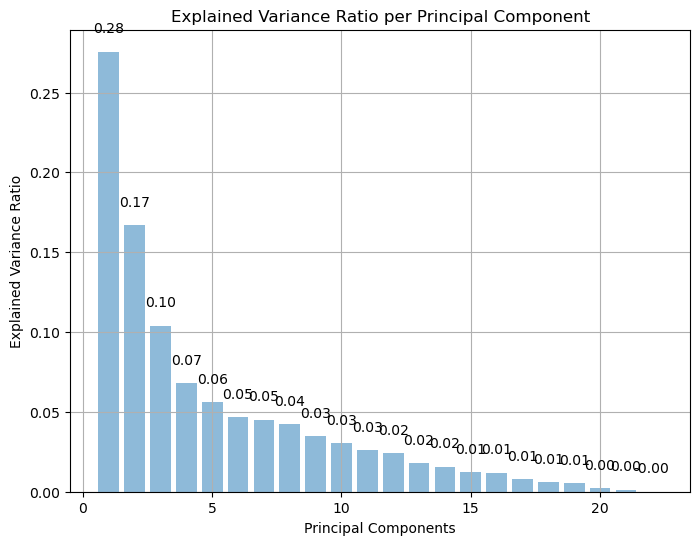

In [20]:
pca_analysis = PCAAnalysis(data_analyze.dataset, data_analyze.get_targets(), len(data_analyze.dataset.columns))
pca_analysis.plot_explained_variance_ratio()